In [507]:
from importing_sb import *
from pitch_plotting import *
import numpy as np
import pandas as pd
import matplotlib as mpl
from cycler import cycler
from highlight_text.htext import htext, fig_htext

mpl.rcParams.update({'axes.prop_cycle':cycler('color', ['#004d98', '#edbb00', '#a50044', 'xkcd:green', 
                                                        '#8c564b', '#9467bd', '#e377c2', '#7f7f7f', 
                                                        '#bcbd22', '#17becf'])})
mpl.rcParams.update({'axes.titlesize':16,'axes.labelsize':14,'lines.linewidth':3,'lines.markersize':10,'lines.markeredgewidth':2})
mpl.rcParams.update({'font.family': ['sans-serif'],'font.sans-serif':['Arimo','Nunito','Helonia','Source Sans Pro',
                    'DejaVu Sans',
                    'Bitstream Vera Sans',
                    'Computer Modern Sans Serif',
                    'Lucida Grande',
                    'Verdana',                  
                    'Geneva',
                    'Lucid',
                    'Arial',
                    'Helvetica',
                    'Avant Garde',
                    'sans-serif']})

data_dir = 'data/open-data/data/'

comp_data = open_data(data_dir + 'competitions.json')
la_liga_seasons = [i['season_id'] for i in comp_data if i['competition_id'] == 11]
match_data = [sorted(open_data(data_dir + 'matches/11/{}.json'.format(i)), key = lambda k:k['match_date']) for i in la_liga_seasons]

comp_df = pd.DataFrame(comp_data)
#match_df = pd.DataFrame(match_data)

In [457]:
mpl.rc_params();

In [653]:
years = list(range(2018,2003,-1))
seasons = ['18/19','17/18','16/17','15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06','04/05']
match_id = {}
for i in range(len(years)):
    df = pd.DataFrame(match_data[i])
    match_id[str(years[i])] = df['match_id'].values

In [24]:
event_data = {}
lineup_data = {}
for year in years:
    event_data[str(year)] = []
    lineup_data[str(year)] = []
    for match in match_id[str(year)]:
        event_data[str(year)].append(open_data(data_dir + 'events/{}.json'.format(str(match))))
        lineup_data[str(year)].append(open_data(data_dir + 'lineups/{}.json'.format(str(match))))

In [72]:
nicknames = {}
for year in years:
    for match in lineup_data[str(year)]:
        for team in match:
            if team['team_name'] == 'Barcelona':
                for players in team['lineup']:
                    if players['player_nickname'] == None:
                        nicknames[str(players['player_name'])] = str(players['player_name'])
                    else:
                        nicknames[str(players['player_name'])] = str(players['player_nickname'])

In [555]:
event_data_15 = [i for match in event_data['2015'] for i in match]
event_data_18 = [i for match in event_data['2018'] for i in match]

In [77]:
messi = 'Lionel Andrés Messi Cuccittini'

In [78]:
# Calculate amount of 90s played per season
m_90_played = []
for year in years:
    tot = 0
    for i in range(len(event_data[str(year)])):
        tot += get_player_info(event_data[str(year)][i],messi).sec_played
        
    m_90_played.append((tot / 60) / 90)

In [79]:
m_90_played

[31.462407407407408,
 34.59962962962963,
 32.50074074074074,
 31.193703703703704,
 38.763888888888886,
 28.72759259259259,
 30.458333333333332,
 37.52240740740741,
 32.82055555555556,
 32.55166666666667,
 28.943333333333335,
 22.907777777777774,
 22.799074074074074,
 10.357037037037037,
 1.0203703703703704]

## Shots

In [80]:
shots = {}
for year in years:
    shots[str(year)] = [get_shots(match) for match in event_data[str(year)]]

In [81]:
shots_seas = {}
for year in shots:
    shots_seas[str(year)] = pd.concat(shots[str(year)])
    shots_seas[str(year)].reset_index(inplace=True)

In [656]:
m_shots_seas = {}
barca_shots_seas = {}
for year in years:
    m_shots_seas[str(year)] = shots_seas[str(year)][shots_seas[str(year)]['player'] == messi]
    barca_shots_seas[str(year)] = shots_seas[str(year)][shots_seas[str(year)]['team'] == 'Barcelona']

In [138]:
m_seas_h = {}
m_seas_lf = {}
m_seas_rf = {}
for year in years:
    m_seas_h[str(year)] = m_shots_seas[str(year)][(m_shots_seas[str(year)]['body_part'] == 'Head')]
    m_seas_lf[str(year)] = m_shots_seas[str(year)][(m_shots_seas[str(year)]['body_part'] == 'Left Foot')]
    m_seas_rf[str(year)] = m_shots_seas[str(year)][(m_shots_seas[str(year)]['body_part'] == 'Right Foot')]

In [83]:
m_h = np.array([len(m_shots_seas[str(i)][m_shots_seas[str(i)]['body_part'] == 'Head']) for i in years])
m_h_g = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Head')&(m_shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
m_lf = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Left Foot')]) for i in years])
m_lf_g = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Left Foot')&(m_shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
m_rf = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Right Foot')]) for i in years])
m_rf_g = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Right Foot')&(m_shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])

h = np.array([len(shots_seas[str(i)][shots_seas[str(i)]['body_part'] == 'Head']) for i in years])
h_g = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Head')&(shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
lf = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Left Foot')]) for i in years])
lf_g = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Left Foot')&(shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
rf = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Right Foot')]) for i in years])
rf_g = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Right Foot')&(shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])

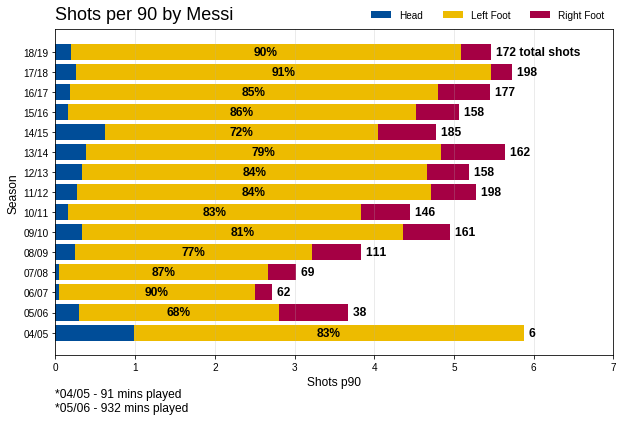

In [511]:
ind = list(reversed(np.arange(len(years))))

fig, ax = plt.subplots(figsize=(10,6))
p1 = ax.barh(ind, m_h / m_90_played,color='#004d98')
p2 = ax.barh(ind, m_lf / m_90_played,left=m_h / m_90_played,color='#edbb00')
p3 = ax.barh(ind, m_rf / m_90_played,left=(m_lf+m_h) / m_90_played,color='#a50044')

#labels = ax.get_xticklabels()
ax.set_yticks(ind)
ax.set_yticklabels(seasons)
ax.set_xlabel('Shots p90',fontsize=12)
ax.set_ylabel('Season',fontsize=12)
ax.set_xlim(0,7)
#ax.set_title('Shots per 90 by Messi')

ax.text(0.0,1.03,'Shots per 90 by Messi',transform=ax.transAxes,fontsize=18)
ax.legend((p1[0], p2[0], p3[0]), ('Head', 'Left Foot', 'Right Foot'),ncol=3,loc=4,bbox_to_anchor=(1.0,1.0),frameon=False)

tshotslabels = ['total shots']
for i in range(len(seasons)-1):
    tshotslabels.append('')

for i in range(len(ind)):
    ax.annotate('{0} {1}'.format((m_h + m_lf + m_rf)[i],tshotslabels[i]),
                    xy=(((m_h + m_lf + m_rf)[i] / m_90_played[i]), ind[i]), xytext=(5,0),
                    textcoords="offset points",
                    ha='left', va='center', fontsize=12, fontweight='bold')
    
ax.text(0.0, -0.1, '*04/05 - 91 mins played\n*05/06 - 932 mins played', ha='left', va='top', transform=ax.transAxes, fontsize=12)

for i in range(len(ind)):
    ax.annotate('{:.0f}%'.format((m_lf[i]/sum([m_h[i],m_lf[i],m_rf[i]])) * 100),
                    xy=(((m_lf[i] / 2) + m_h[i]) / m_90_played[i], ind[i]), xytext=(0,0),
                    textcoords="offset points",
                    ha='center', va='center', fontsize=12, fontweight='bold')

ax.grid(axis='x',alpha=0.3)
    
plt.show()
#fig.savefig('example_plots/messi_shotsp90.pdf',bbox_inches='tight')

/Users/jm533/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


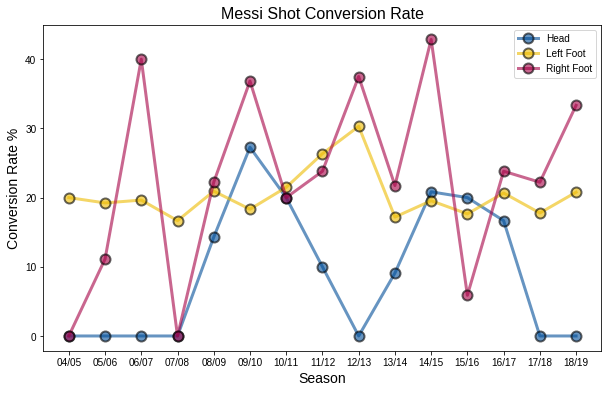

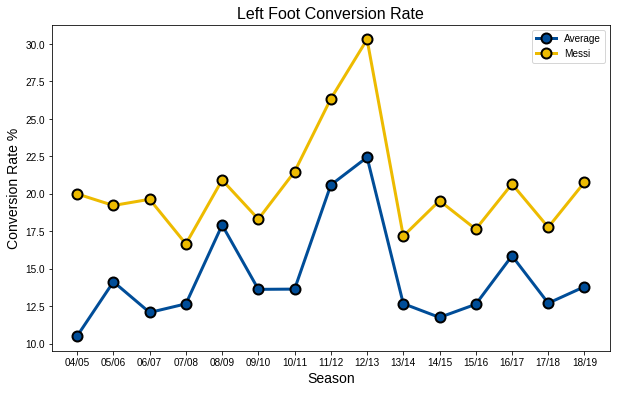

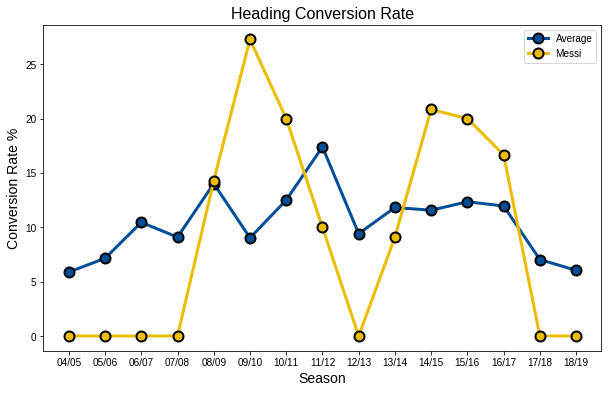

In [512]:
ind = list(reversed(np.arange(len(seasons))))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, (np.array(m_h_g) / np.array(m_h)) * 100, '-o',mec='k',label='Head',alpha=0.6)
ax.plot(ind, (np.array(m_lf_g) / np.array(m_lf)) * 100, '-o',mec='k',label='Left Foot',alpha=0.6)
ax.plot(ind, np.nan_to_num((np.array(m_rf_g) / np.array(m_rf))) * 100, '-o',mec='k',label='Right Foot',alpha=0.6)
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Conversion Rate %',title='Messi Shot Conversion Rate')
ax.legend(loc='best')

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, (np.array(lf_g) / np.array(lf)) * 100, '-o',mec='k',label='Average')
ax.plot(ind, (np.array(m_lf_g) / np.array(m_lf)) * 100, '-o',mec='k',label='Messi')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Conversion Rate %',title='Left Foot Conversion Rate')
ax.legend(loc='best')

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, (np.array(h_g) / np.array(h)) * 100, '-o',mec='k',label='Average')
ax.plot(ind, (np.array(m_h_g) / np.array(m_h)) * 100, '-o',mec='k',label='Messi')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Conversion Rate %',title='Heading Conversion Rate')
ax.legend(loc='best')

plt.show()

When comparing Messi to the average left foot conversion rate what I have done now seems unfair given the right foot is dominant for most players. Rather I should separate players into left foot and right foot dominance, which could be done by looking at all their shots or actions and looking at which is used more. Then I could compare Messi to just left footed players (however realistically this is just Barcelona left-footers) or compare to conversion rate of dominant foot.

In [660]:
m_xg_diff = []
m_xg_diff_h = []
m_xg_diff_lf = []
m_xg_diff_rf = []
b_xg_diff = []
for year in years:
    m_xg_diff.append(len(m_shots_seas[str(year)][m_shots_seas[str(year)]['outcome'] == 'Goal']) - 
    m_shots_seas[str(year)]['sb_xg'].sum())
    b_xg_diff.append(len(barca_shots_seas[str(year)][barca_shots_seas[str(year)]['outcome'] == 'Goal']) - 
    barca_shots_seas[str(year)]['sb_xg'].sum())
    
    m_xg_diff_h.append(len(m_seas_h[str(year)][(m_seas_h[str(year)]['outcome'] == 'Goal')]) - 
    m_seas_h[str(year)]['sb_xg'].sum())
    
    m_xg_diff_lf.append(len(m_seas_lf[str(year)][(m_seas_lf[str(year)]['outcome'] == 'Goal')]) - 
    m_seas_lf[str(year)]['sb_xg'].sum())
    
    m_xg_diff_rf.append(len(m_seas_rf[str(year)][(m_seas_rf[str(year)]['outcome'] == 'Goal')]) - 
    m_seas_rf[str(year)]['sb_xg'].sum())

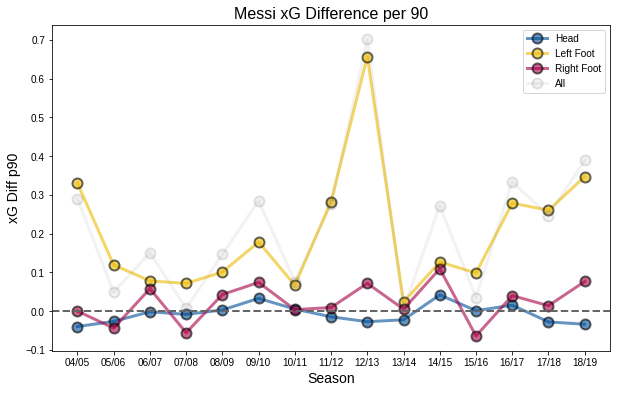

Exlcuding first two seasons
Avg with Head: -0.003
Avg with Left Foot: 0.198
Avg with Right Foot: 0.029


In [659]:
ind = list(reversed(np.arange(len(seasons))))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, np.array(m_xg_diff_h) / np.array(m_90_played), '-o',mec='k',label='Head',alpha=0.6)
ax.plot(ind, np.array(m_xg_diff_lf) / np.array(m_90_played), '-o',mec='k',label='Left Foot',alpha=0.6)
ax.plot(ind, np.array(m_xg_diff_rf) / np.array(m_90_played), '-o',mec='k',label='Right Foot',alpha=0.6)
ax.plot(ind, np.array(m_xg_diff) / np.array(m_90_played), '-o',color='0.5',mec='k',label='All',alpha=0.1)
ax.axhline(0,color='0.4',ls='--',lw=2)
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='xG Diff p90',title='Messi xG Difference per 90')
ax.legend(loc='best')
plt.show()

print('Exlcuding first two seasons\nAvg with Head: {:.3f}'.format(np.mean((np.array(m_xg_diff_h) / np.array(m_90_played))[:-2])))
print('Avg with Left Foot: {:.3f}'.format(np.mean((np.array(m_xg_diff_lf) / np.array(m_90_played))[:-2])))
print('Avg with Right Foot: {:.3f}'.format(np.mean((np.array(m_xg_diff_rf) / np.array(m_90_played))[:-2])))

In [693]:
g_frac = []
xg_frac = []
for y in years:
    g_frac.append(len(m_shots_seas[str(y)][m_shots_seas[str(y)]['outcome'] == 'Goal']) / 
     len(barca_shots_seas[str(y)][barca_shots_seas[str(y)]['outcome'] == 'Goal']))
    xg_frac.append(m_shots_seas[str(y)]['sb_xg'].sum() / barca_shots_seas[str(y)]['sb_xg'].sum())

In [666]:
matches_played = []
for year in years:
    matches_played.append(len(event_data[str(year)]))

In [691]:
print(len(barca_shots_seas['2018'][barca_shots_seas['2018']['outcome'] == 'Goal']))
print(len(m_shots_seas['2018'][m_shots_seas['2018']['outcome'] == 'Goal']))
print(len(m_shots_seas['2018'][m_shots_seas['2018']['outcome'] == 'Goal']) / 
     len(barca_shots_seas['2018'][barca_shots_seas['2018']['outcome'] == 'Goal']))

80
36
0.45


In [692]:
print(barca_shots_seas['2018']['sb_xg'].sum())
print(m_shots_seas['2018']['sb_xg'].sum())
print(m_shots_seas['2018']['sb_xg'].sum() / barca_shots_seas['2018']['sb_xg'].sum())

69.49552324899999
23.752841874999998
0.3417895249150713


In [672]:
b_xg_diff_p90 = np.array(b_xg_diff) / np.array(matches_played)

In [671]:
m_xg_diff_p90 = np.array(m_xg_diff) / np.array(m_90_played)

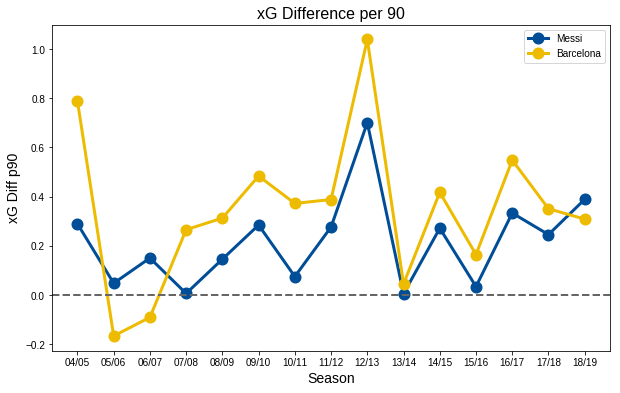

In [714]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,m_xg_diff_p90,'-o',label='Messi')
ax.plot(ind,b_xg_diff_p90,'-o',label='Barcelona')
ax.axhline(0,color='0.4',ls='--',lw=2)
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='xG Diff p90',title='xG Difference per 90')
ax.legend(loc='best')

plt.show()

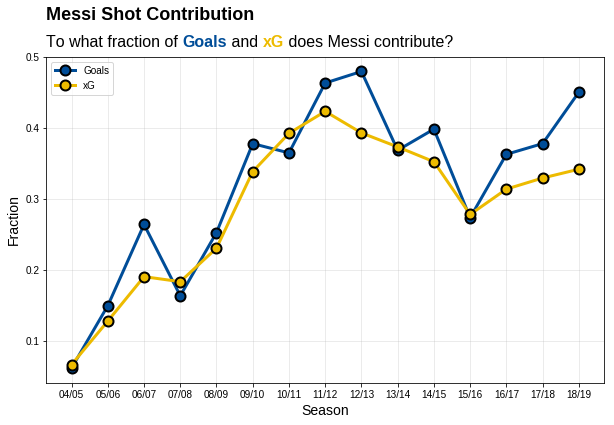

In [742]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,g_frac,'-o',mec='k',label='Goals')
ax.plot(ind,xg_frac,'-o',mec='k',label='xG')
ax.grid(alpha=0.3)
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Fraction')
ax.legend(loc='best')
ax.text(0.0,1.1,'Messi Shot Contribution',ha='left',va='bottom',transform=ax.transAxes,fontsize=18,fontweight='semibold')
#ax.text(0.0,1.0,'To what fraction of ',ha='left',va='bottom',transform=ax.transAxes,fontsize='16')
htext(s = 'To what fraction of <Goals> and <xG> does Messi contribute?',x = -0.7, y = 0.51,color = 'k', 
      highlight_colors = ['#004d98','#edbb00'],fontsize=16,string_weight = 'regular',
      highlight_weights=['bold'])


plt.show()

## Passes

In [514]:
passes = {}
for year in years:
    passes[str(year)] = [get_pass(match) for match in event_data[str(year)]]

In [515]:
passes_seas = {}
for year in passes:
    passes_seas[str(year)] = pd.concat(passes[str(year)])
    passes_seas[str(year)].reset_index(inplace=True)

In [677]:
b_xg_diff_p90

array([ 0.3089552 ,  0.35107563,  0.54865306,  0.16483371,  0.41769007,
        0.0454388 ,  1.03878564,  0.38856008,  0.37266836,  0.48398883,
        0.31313029,  0.26591519, -0.09013001, -0.16584076,  0.78858685])

In [678]:
m_xg_diff_p90

array([0.38926322, 0.24607889, 0.33356261, 0.03484762, 0.27186338,
       0.00585746, 0.70083606, 0.27687164, 0.0755758 , 0.28484184,
       0.14619778, 0.00689011, 0.15086468, 0.04836515, 0.29001969])

In [689]:
(b_xg_diff_p90 - m_xg_diff_p90)

array([-0.08030802,  0.10499674,  0.21509045,  0.12998609,  0.14582668,
        0.03958134,  0.33794958,  0.11168845,  0.29709256,  0.19914699,
        0.16693251,  0.25902509, -0.24099469, -0.21420591,  0.49856716])

In [685]:
m_xg_diff_p90 / (b_xg_diff_p90 + m_xg_diff_p90)

array([ 0.55750924,  0.41208579,  0.37809645,  0.17451617,  0.39426006,
        0.11418887,  0.40286693,  0.41607821,  0.1686041 ,  0.37048709,
        0.31828619,  0.02525649,  2.4839959 , -0.41170381,  0.26888368])

In [516]:
m_pass_seas = {}
m_pass_op_seas ={}
for year in years:
    m_pass_seas[str(year)] = passes_seas[str(year)][passes_seas[str(year)]['player'] == messi]
    m_pass_op_seas[str(year)] = passes_seas[str(year)][(passes_seas[str(year)]['player'] == messi)&
                                                       (passes_seas[str(year)]['pass_type'] == 'Standard')]

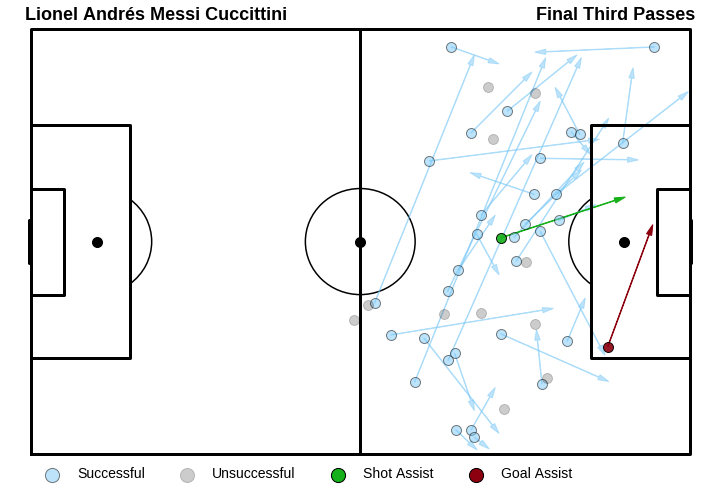

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26d631d68>)

In [517]:
pass_map_player(event_data['2015'][3],messi,'third')

In [711]:
passes_seas['2018']['xA'].sum()
passes_seas['2018'][passes_seas['2018']['player'] == messi]['xA'].sum

13.622813492

### Pass Quantity

In [713]:
13/62

0.20967741935483872

In [518]:
m_pass_op_tot = [len(m_pass_op_seas[str(i)]) for i in years]
m_ft_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['end_x'] >= 80.]) for i in years]
m_box_pass_op_tot = [len(m_pass_op_seas[str(i)][(m_pass_op_seas[str(i)]['end_x'] >= 102.)&
                                                (m_pass_op_seas[str(i)]['end_y'] >= 18.)&
                                                (m_pass_op_seas[str(i)]['end_y'] <= 62.)]) for i in years]

In [519]:
m_pass_p90 = np.array(m_pass_op_tot) / np.array(m_90_played)
m_ft_pass_p90 = np.array(m_ft_pass_op_tot) / np.array(m_90_played)
m_box_pass_p90 = np.array(m_box_pass_op_tot) / np.array(m_90_played)

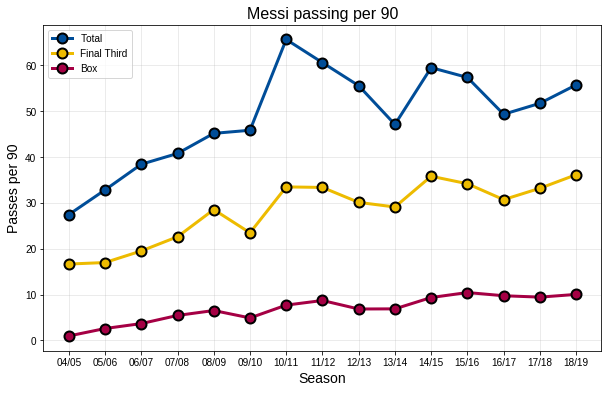

In [520]:
ind = np.flip(np.arange(len(years)))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,m_pass_p90,'-o',mec='k',label='Total')
ax.plot(ind,m_ft_pass_p90,'-o',mec='k',label='Final Third')
ax.plot(ind,m_box_pass_p90,'-o',mec='k',label='Box')

ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Passes per 90',title='Messi passing per 90')
ax.legend(loc=2)

ax.grid(True,alpha=0.3)

plt.show()

### What about types of passes?

In [525]:
m_thru_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['technique'] == 'Through Ball']) for i in years]
m_cross_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['cross'] == True]) for i in years]
m_switch_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['switch'] == True]) for i in years]

In [526]:
m_thru_p90 = np.array(m_thru_pass_op_tot) / np.array(m_90_played)
m_cross_p90 = np.array(m_cross_pass_op_tot) / np.array(m_90_played)
m_switch_p90 = np.array(m_switch_pass_op_tot) / np.array(m_90_played)

In [543]:
man_dates = [0,3+(8/12),7+(9/12),8+(10/12),9+(8/12),12+(9/12)]
man_names = ['Rijkaard','Guardiola','Vilanova','Martino','Enrique','Valverde']

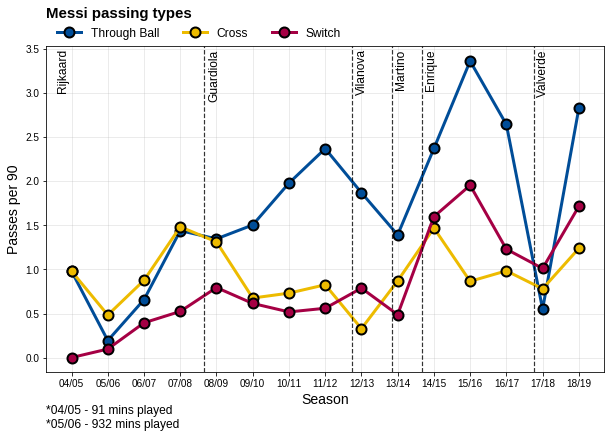

In [544]:
ind = np.flip(np.arange(len(years)))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,m_thru_p90,'-o',mec='k',label='Through Ball')
ax.plot(ind,m_cross_p90,'-o',mec='k',label='Cross')
ax.plot(ind,m_switch_p90,'-o',mec='k',label='Switch')

for i in range(len(man_dates)-1):
    ax.axvline(man_dates[i+1],0,1,c='k',ls='--',lw=1.2,alpha=0.8)
    ax.text(man_dates[i+1]+0.1,3.5,man_names[i+1],fontsize=12,ha='left',va='top',rotation=90)
    
ax.text(man_dates[0]-0.4,3.5,man_names[0],fontsize=12,ha='left',va='top',rotation=90)
    
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Passes per 90')
ax.legend(loc=2,bbox_to_anchor=(0,1.09),ncol=3,frameon=False,fontsize=12)

ax.text(0.0,1.12,'Messi passing types',ha='left', va='top',transform=ax.transAxes,fontsize=15,fontweight='semibold')
ax.text(0.0, -0.1, '*04/05 - 91 mins played\n*05/06 - 932 mins played', ha='left', va='top', transform=ax.transAxes, fontsize=12)

ax.grid(True,alpha=0.3)

plt.show()
#fig.savefig('example_plots/messi_pass_type_p90.pdf',bbox_inches='tight')

In [545]:
m_pass_match = {}
for year in list(reversed(years)):
    m_pass_match[str(year)] = []
    for i in range(len(passes[str(year)])):
        m_pass_match[str(year)].append(passes[str(year)][i][(passes[str(year)][i]['player'] == messi)&
                                                     (passes[str(year)][i]['pass_type'] == 'Standard')])

In [546]:
m_pass_op_match = {}
for year in list(reversed(years)):
    m_pass_op_match[str(year)] = []
    for i in range(len(m_pass_match[str(year)])):
        m_pass_op_match[str(year)].append(len(m_pass_match[str(year)][i]))

In [547]:
m_pass_temp = [*m_pass_op_match.values()]
m_pass_all_df = pd.DataFrame([val for sublist in m_pass_temp for val in sublist])

In [548]:
roll_avg = m_pass_all_df.rolling(6).mean().values

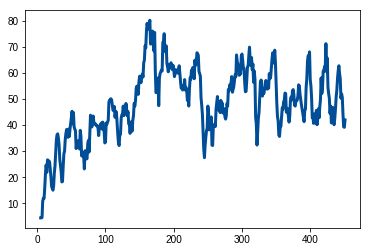

In [549]:
plt.plot(np.arange(len(roll_avg)),roll_avg)

## Carries and Dribbles

In [556]:
m_car_prog_15 = get_carry_prog(event_data_18,find_success=True,player=messi)

In [551]:
m_car_prog_15;

In [557]:
print(m_car_prog_15[m_car_prog_15['xA'].notna()].xA.sum())
print(m_car_prog_15[m_car_prog_15['xG'].notna()].xG.sum())

3.7248932669999997
3.7184249790000004


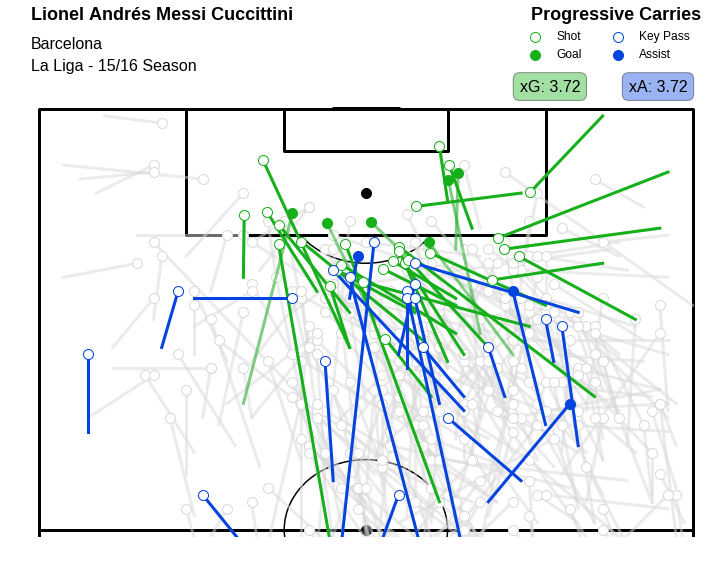

In [558]:
fig, ax = draw_pitch('w','k','v','h')

m_car_s = m_car_prog_15[m_car_prog_15['outcome'] == 'Successful']
m_car_u = m_car_prog_15[m_car_prog_15['outcome'] == 'Unsuccessful']
m_car_shot = m_car_prog_15[(m_car_prog_15['shot_outcome'] != 'Goal')&(m_car_prog_15['shot_outcome'].notnull())]
m_car_goal = m_car_prog_15[(m_car_prog_15['shot_outcome'] == 'Goal')]
m_car_pass = m_car_s[(m_car_s['pass_outcome'].notnull())]
m_car_sa = m_car_pass[(m_car_pass['pass_outcome'] == 'Shot Assist')]
m_car_ga = m_car_pass[(m_car_pass['pass_outcome'] == 'Goal Assist')]
m_car_drib = m_car_s[(m_car_s['dribble_outcome'].notnull())]

xA_tot = m_car_prog_15[m_car_prog_15['xA'].notna()].xA.sum()
xG_tot = m_car_prog_15[m_car_prog_15['xG'].notna()].xG.sum()

xs = m_car_s['x'].values
ys = m_car_s['y'].values
xse = m_car_s['end_x'].values
yse = m_car_s['end_y'].values

xsh = m_car_shot['x'].values
ysh = m_car_shot['y'].values
xshe = m_car_shot['end_x'].values
yshe = m_car_shot['end_y'].values

xg = m_car_goal['x'].values
yg = m_car_goal['y'].values
xge = m_car_goal['end_x'].values
yge = m_car_goal['end_y'].values

xsa = m_car_sa['x'].values
ysa = m_car_sa['y'].values
xsae = m_car_sa['end_x'].values
ysae = m_car_sa['end_y'].values

xga = m_car_ga['x'].values
yga = m_car_ga['y'].values
xgae = m_car_ga['end_x'].values
ygae = m_car_ga['end_y'].values

xd = m_car_drib['x'].values
yd = m_car_drib['y'].values
xde = m_car_drib['end_x'].values
yde = m_car_drib['end_y'].values

zo=100
ax.plot([ys,yse],[xs,xse],'0.85',alpha=0.5,zorder=zo)
ax.scatter(yse,xse,s=100,facecolor='w',edgecolor='0.85',zorder=zo+1)
ax.plot([ysh,yshe],[xsh,xshe],'xkcd:green',alpha=1,zorder=zo+2)
ax.scatter(yshe,xshe,s=100,facecolor='w',edgecolor='xkcd:green',zorder=zo+3)
ax.plot([yg,yge],[xg,xge],'xkcd:green',alpha=0.5,zorder=zo+2)
ax.scatter(yge,xge,s=100,facecolor='xkcd:green',edgecolor='xkcd:green',zorder=zo+3)
ax.plot([ysa,ysae],[xsa,xsae],'xkcd:blue',alpha=1,zorder=zo+2)
ax.scatter(ysae,xsae,s=100,facecolor='w',edgecolor='xkcd:blue',zorder=zo+3)
ax.plot([yga,ygae],[xga,xgae],'xkcd:blue',alpha=1,zorder=zo+2)
ax.scatter(ygae,xgae,s=100,facecolor='xkcd:blue',edgecolor='xkcd:blue',zorder=zo+3)

ax.text(0.0,1.18,messi,transform=ax.transAxes,ha='left',va='bottom',fontsize=18,fontweight='semibold',zorder=zo)
ax.text(0.0,1.15,'Barcelona',transform=ax.transAxes,ha='left',va='top',fontsize=16,zorder=zo)
ax.text(0.0,1.10,'La Liga - 15/16 Season',transform=ax.transAxes,ha='left',va='top',fontsize=16,zorder=zo,)
ax.text(1.0,1.18,'Progressive Carries',transform=ax.transAxes,ha='right',va='bottom',fontsize=18,fontweight='semibold',zorder=zo)

ax.scatter(-100,-100,s=100,facecolor='w',edgecolor='xkcd:green',zorder=zo+3,label='Shot')
ax.scatter(-100,-100,s=100,facecolor='xkcd:green',edgecolor='xkcd:green',zorder=zo+3,label='Goal')
ax.scatter(-100,-100,s=100,facecolor='w',edgecolor='xkcd:blue',zorder=zo+3,label='Key Pass')
ax.scatter(-100,-100,s=100,facecolor='xkcd:blue',edgecolor='xkcd:blue',zorder=zo+3,label='Assist')

ax.legend(loc=4,bbox_to_anchor=(1.0,1.07),ncol=2,frameon=False,fontsize=12,framealpha=0,facecolor=None)

ax.text(0.82,1.025,'xG: {:.2f}'.format(xG_tot),transform=ax.transAxes,fontsize=16,
        bbox=dict(boxstyle='round,pad=0.4',facecolor='xkcd:green',edgecolor='k',alpha=0.4),ha='right',zorder=zo)
ax.text(0.98,1.025,'xA: {:.2f}'.format(xA_tot),transform=ax.transAxes,fontsize=16,
        bbox=dict(boxstyle='round,pad=0.4',facecolor='xkcd:blue',edgecolor='k',alpha=0.4),ha='right',zorder=zo)

plt.show()
#fig.savefig('example_plots/carry_map.pdf',bbox_inches='tight')

In [559]:
m_carries = {}
for year in years:
    m_carries[str(year)] = [get_carry_prog(match,find_success=True,player=messi) for match in event_data[str(year)]]

In [560]:
m_car_seas = {}
m_car_seas_suc = {}
for year in m_carries:
    m_car_seas[str(year)] = pd.concat(m_carries[str(year)])
    m_car_seas[str(year)].reset_index(inplace=True)
    m_car_seas_suc[str(year)] = m_car_seas[str(year)][m_car_seas[str(year)]['outcome'] == 'Successful']

In [561]:
m_car_seas_box = {}
m_car_seas_box_suc = {}
for year in m_carries:
    m_car_seas_box[str(year)] = m_car_seas[str(year)][(m_car_seas[str(year)]['end_x'] >= 102)&(m_car_seas[str(year)]['end_y'] >= 18)&(m_car_seas[str(year)]['end_y'] <= 62)&((m_car_seas[str(year)]['x'] <= 102)|(m_car_seas[str(year)]['y'] <= 18)|(m_car_seas[str(year)]['y'] >= 62))]
    m_car_seas_box_suc[str(year)] = m_car_seas_box[str(year)][m_car_seas_box[str(year)]['outcome'] == 'Successful']

In [562]:
car_p_suc_frac = np.array([(len(m_car_seas_suc[str(years[i])]) / len(m_car_seas[str(years[i])])) for i in range(len(years))])
car_p_tot_p90 = np.array([(len(m_car_seas[str(years[i])]) / m_90_played[i]) for i in range(len(years))])
car_p_suc_p90 = np.array([(len(m_car_seas_suc[str(years[i])]) / m_90_played[i]) for i in range(len(years))])
car_p_tot_dist = np.array([m_car_seas[str(years[i])]['carry_dist'].mean() for i in range(len(years))])
car_p_suc_dist = np.array([m_car_seas_suc[str(years[i])]['carry_dist'].mean() for i in range(len(years))])

car_p_pass_frac = np.array([len(m_car_seas[str(years[i])][m_car_seas[str(years[i])]['pass_outcome'].notna()]) / len(m_car_seas[str(years[i])]) for i in range(len(years))])
car_p_shot_frac = np.array([len(m_car_seas[str(years[i])][m_car_seas[str(years[i])]['shot_outcome'].notna()]) / len(m_car_seas[str(years[i])]) for i in range(len(years))])
car_p_drib_frac = np.array([len(m_car_seas[str(years[i])][m_car_seas[str(years[i])]['dribble_outcome'].notna()]) / len(m_car_seas[str(years[i])]) for i in range(len(years))])
car_p_pass_frac_s = np.array([len(m_car_seas_suc[str(years[i])][m_car_seas_suc[str(years[i])]['pass_outcome'].notna()]) / len(m_car_seas_suc[str(years[i])]) for i in range(len(years))])
car_p_shot_frac_s = np.array([len(m_car_seas_suc[str(years[i])][m_car_seas_suc[str(years[i])]['shot_outcome'].notna()]) / len(m_car_seas_suc[str(years[i])]) for i in range(len(years))])
car_p_drib_frac_s = np.array([len(m_car_seas_suc[str(years[i])][m_car_seas_suc[str(years[i])]['dribble_outcome'].notna()]) / len(m_car_seas_suc[str(years[i])]) for i in range(len(years))])

car_p_xG = np.array([m_car_seas[str(years[i])]['xG'].sum() for i in range(len(years))])
car_p_xA = np.array([m_car_seas[str(years[i])]['xA'].sum() for i in range(len(years))])
car_p_xG_p90 = np.array([m_car_seas[str(years[i])]['xG'].sum() / m_90_played[i] for i in range(len(years))])
car_p_xA_p90 = np.array([m_car_seas[str(years[i])]['xA'].sum() / m_90_played[i] for i in range(len(years))])

car_p_tot_box = np.array([len(m_car_seas_box[str(years[i])]) for i in range(len(years))])
car_p_suc_box = np.array([len(m_car_seas_box_suc[str(years[i])]) for i in range(len(years))])
car_p_tot_box_p90 = car_p_tot_box / np.array(m_90_played)
car_p_suc_box_p90 = car_p_suc_box / np.array(m_90_played)

car_p_pass_box = np.array([len(m_car_seas_box[str(years[i])][m_car_seas_box[str(years[i])]['pass_outcome'].notna()]) / len(m_car_seas_box[str(years[i])]) for i in range(len(years))])
car_p_shot_box = np.array([len(m_car_seas_box[str(years[i])][m_car_seas_box[str(years[i])]['shot_outcome'].notna()]) / len(m_car_seas_box[str(years[i])]) for i in range(len(years))])
car_p_drib_box = np.array([len(m_car_seas_box[str(years[i])][m_car_seas_box[str(years[i])]['dribble_outcome'].notna()]) / len(m_car_seas_box[str(years[i])]) for i in range(len(years))])
car_p_pass_box_s = np.array([len(m_car_seas_box_suc[str(years[i])][m_car_seas_box_suc[str(years[i])]['pass_outcome'].notna()]) / len(m_car_seas_box_suc[str(years[i])]) for i in range(len(years))])
car_p_shot_box_s = np.array([len(m_car_seas_box_suc[str(years[i])][m_car_seas_box_suc[str(years[i])]['shot_outcome'].notna()]) / len(m_car_seas_box_suc[str(years[i])]) for i in range(len(years))])
car_p_drib_box_s = np.array([len(m_car_seas_box_suc[str(years[i])][m_car_seas_box_suc[str(years[i])]['dribble_outcome'].notna()]) / len(m_car_seas_box_suc[str(years[i])]) for i in range(len(years))])


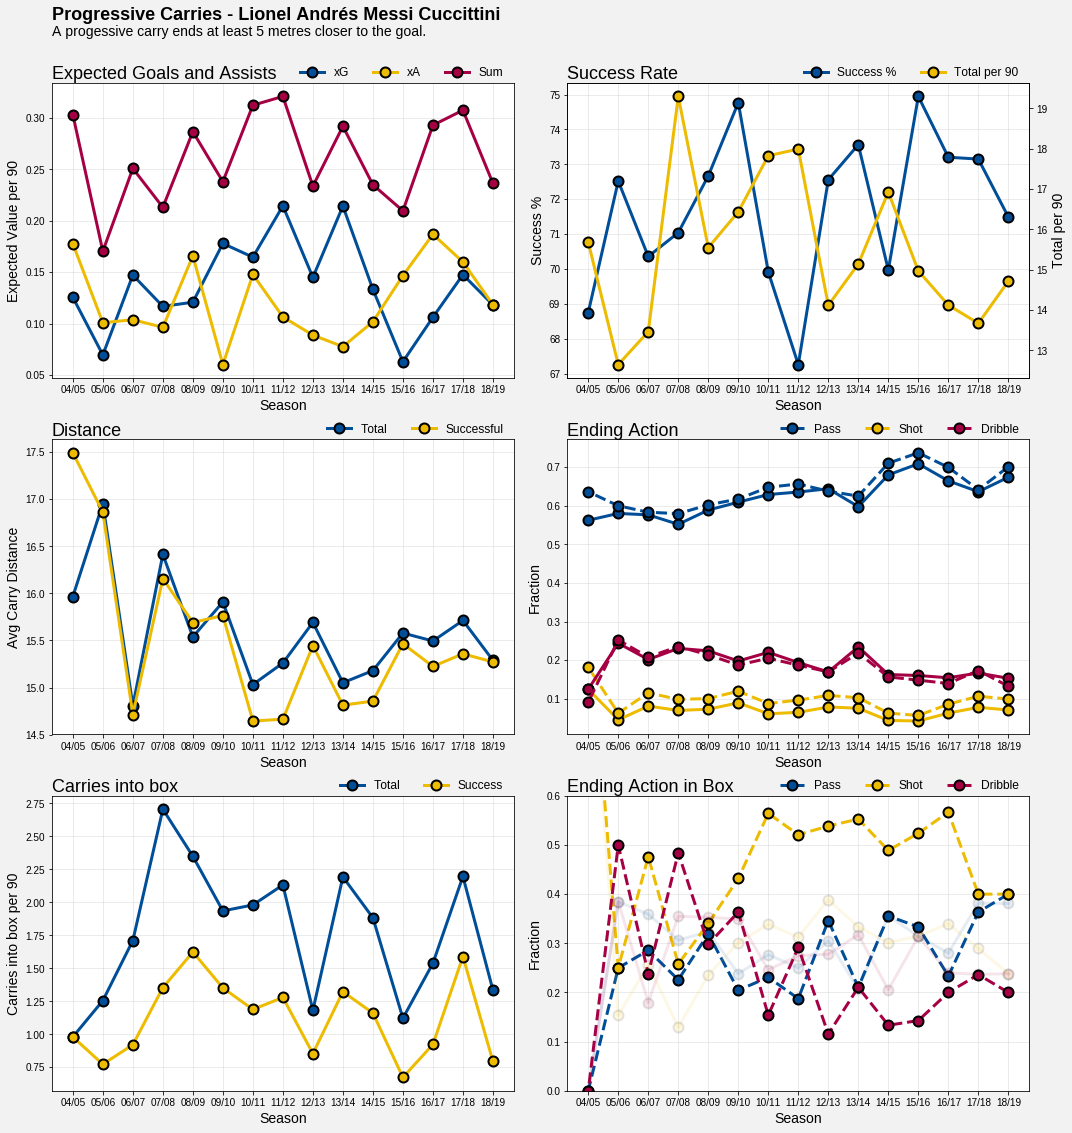

In [563]:
import matplotlib as mpl
#mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams.update({'axes.labelsize':14,'lines.linewidth':3,'lines.markersize':10})

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,sharex='row',figsize=(15,15),facecolor='0.95')

ind = np.flip((np.arange(len(years))))

zo=100

ax1.text(0.0,1.2,'Progressive Carries - ' + messi,transform=ax1.transAxes,ha='left',va='bottom',fontsize=18,fontweight='semibold',zorder=zo)
ax1.text(0.0,1.15,'A progessive carry ends at least 5 metres closer to the goal.',transform=ax1.transAxes,ha='left',va='bottom',fontsize=14,zorder=zo)

ax1.plot(ind, car_p_xG_p90,'-o',c='#004d98',mec='k',label='xG')
ax1.plot(ind, car_p_xA_p90,'-o',c='#edbb00',mec='k',label='xA')
ax1.plot(ind, car_p_xG_p90+car_p_xA_p90,'-o',c='#a50044',mec='k',label='Sum')
ax1.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Expected Value per 90')
ax1.legend(loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax1.text(0.0,1.0,'Expected Goals and Assists',transform=ax1.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax1.grid(alpha=0.3)

suc = ax2.plot(ind, car_p_suc_frac*100,'-o',c='#004d98',mec='k')
ax2r = ax2.twinx()
tot = ax2r.plot(ind, car_p_tot_p90,'-o',c='#edbb00',mec='k')
#tot = ax2r.plot(ind, car_p_tot_dist,'-o',c='#edbb00',mec='k')
ax2.set(xlabel='Season',ylabel='Success %')
ax2r.set(ylabel='Total per 90')
ax2.legend([suc[0],tot[0]],['Success %','Total per 90'],loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax2.text(0.0,1.0,'Success Rate',transform=ax2.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax2.grid(alpha=0.3)

tot = ax3.plot(ind, car_p_tot_dist,'-o',c='#004d98',mec='k')
#ax3r = ax3.twinx()
suc = ax3.plot(ind, car_p_suc_dist,'-o',c='#edbb00',mec='k')
ax3.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Avg Carry Distance')
#ax3r.set(ylabel='Avg Successful Distance per 90')
ax3.legend([tot[0],suc[0]],['Total','Successful'],loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax3.text(0.0,1.0,'Distance',transform=ax3.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax3.grid(alpha=0.3)

pas = ax4.plot(ind, car_p_pass_frac,'-o',c='#004d98',mec='k')
pas = ax4.plot(ind, car_p_pass_frac_s,'--o',c='#004d98',mec='k')
shot = ax4.plot(ind, car_p_shot_frac,'-o',c='#edbb00',mec='k')
shot = ax4.plot(ind, car_p_shot_frac_s,'--o',c='#edbb00',mec='k')
drib = ax4.plot(ind, car_p_drib_frac,'-o',c='#a50044',mec='k')
drib = ax4.plot(ind, car_p_drib_frac_s,'--o',c='#a50044',mec='k')
ax4.set(xlabel='Season',ylabel='Fraction')
ax4.legend([pas[0],shot[0],drib[0]],['Pass','Shot','Dribble'],loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax4.text(0.0,1.0,'Ending Action',transform=ax4.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax4.grid(alpha=0.3)

ax5.plot(ind, car_p_tot_box_p90,'-o',c='#004d98',mec='k',label='Total')
ax5.plot(ind, car_p_suc_box_p90,'-o',c='#edbb00',mec='k',label='Success')
ax5.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Carries into box per 90')
ax5.legend(loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax5.text(0.0,1.0,'Carries into box',transform=ax5.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax5.grid(alpha=0.3)

pas = ax6.plot(ind, car_p_pass_box,'-o',c='#004d98',mec='k',alpha=0.1)
pas = ax6.plot(ind, car_p_pass_box_s,'--o',c='#004d98',mec='k')
shot = ax6.plot(ind, car_p_shot_box,'-o',c='#edbb00',mec='k',alpha=0.1)
shot = ax6.plot(ind, car_p_shot_box_s,'--o',c='#edbb00',mec='k')
drib = ax6.plot(ind, car_p_drib_box,'-o',c='#a50044',mec='k',alpha=0.1)
drib = ax6.plot(ind, car_p_drib_box_s,'--o',c='#a50044',mec='k')
ax6.set(xlabel='Season',ylabel='Fraction',ylim=(0.0,0.6))
ax6.legend([pas[0],shot[0],drib[0]],['Pass','Shot','Dribble'],loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax6.text(0.0,1.0,'Ending Action in Box',transform=ax6.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()
#fig.savefig('example_plots/messi_carries.pdf',bbox_inches='tight')

In [564]:
sum_rescale = (car_p_xG_p90+car_p_xA_p90-min(car_p_xG_p90+car_p_xA_p90)) / (max(car_p_xG_p90+car_p_xA_p90)-min(car_p_xG_p90+car_p_xA_p90))
dist_tot_rescale = (car_p_tot_dist-min(car_p_tot_dist)) / (max(car_p_tot_dist)-min(car_p_tot_dist))
dist_tot_rescale_flip = (car_p_tot_dist-max(car_p_tot_dist)) / (min(car_p_tot_dist)-max(car_p_tot_dist))
dist_suc_rescale = (car_p_suc_dist-min(car_p_suc_dist)) / (max(car_p_suc_dist)-min(car_p_suc_dist))
dist_suc_rescale_flip = (car_p_suc_dist-max(car_p_suc_dist)) / (min(car_p_suc_dist)-max(car_p_suc_dist))

While it is quite difficult to see whether any of these facets of carries affect the total offensive contribution (xG + xA), something to note is the relationship between Total Offensive Contribution and the average distance of a carry. It appears that their behaviours are opposite. **Increases** in carry distance **decrease** xG + xA.

Typically it is seen that a greater carry distance is a good thing as it means more progress towards the opposition goal. However, in terms of the xG + xA output of Messi, the opposite is true.

Below is the plot of rescaled xG + xA and the Average Carry Distance which has also been flipped (such that the minimum carry distances are now maximum, just so the relationship between the two is clearer).

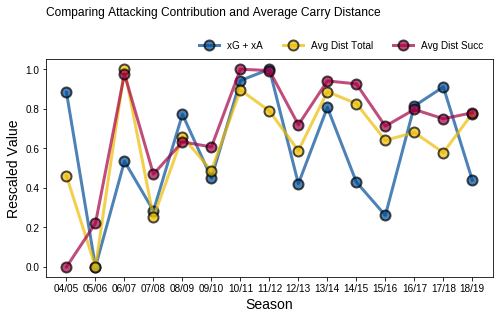

In [565]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(ind,sum_rescale,'-o',alpha=0.7,mec='k',label='xG + xA')
ax.plot(ind,dist_tot_rescale_flip,'-o',alpha=0.7,mec='k',label='Avg Dist Total')
ax.plot(ind,dist_suc_rescale_flip,'-o',alpha=0.7,mec='k',label='Avg Dist Succ')

ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Rescaled Value')
ax.text(0,1.2,'Comparing Attacking Contribution and Average Carry Distance',transform=ax.transAxes,fontsize=12)
ax.legend(loc=4,bbox_to_anchor=(1.0,1.0),ncol=3,frameon=False,fontsize=10)
plt.show()

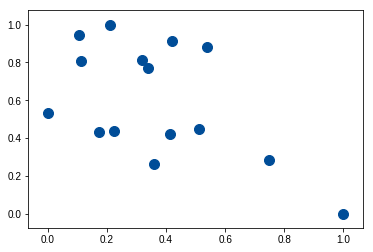

In [566]:
plt.scatter(dist_tot_rescale,sum_rescale)

## Differences between Passes and Passes After Carries

### Using Progressive Carries

In [567]:
m_pass_op_seas['2015']['event_id'].values[0]
pass_c = m_car_seas['2015'][m_car_seas['2015']['pass_outcome'].notna()]

In [568]:
pass_c = {}
pass_nc = {}
for year in years:
    cond_list = []
    pass_c[str(year)] = m_car_seas[str(year)][m_car_seas[str(year)]['pass_outcome'].notna()]
    for i in m_pass_op_seas[str(year)]['event_id'].values:
        val = i not in pass_c[str(year)]['outcome_id'].values #m_car_seas['2015']['outcome_id'].values
        cond_list.append(val)
    pass_nc[str(year)] = m_pass_op_seas[str(year)][cond_list]

In [569]:
# Excluding 04/05
#years = [2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005]
years = list(range(2018,2004,-1))

pass_nc_ratio = np.array([len(pass_nc[str(years[i])][pass_nc[str(years[i])]['outcome'] == 'Complete']) / len(pass_nc[str(years[i])]) for i in range(len(years))])
pass_c_ratio = np.array([len(pass_c[str(years[i])][pass_c[str(years[i])]['pass_outcome'] != 'Incomplete']) / len(pass_c[str(years[i])]) for i in range(len(years))])
pass_ratio = np.array([len(pass_c[str(years[i])]) / (len(pass_nc[str(years[i])]) + len(pass_c[str(years[i])])) for i in range(len(years))])

pass_nc_xA = np.array([pass_nc[str(years[i])]['xA'].sum() / m_90_played[i] for i in range(len(years))])
pass_c_xA = np.array([pass_c[str(years[i])]['xA'].sum() / m_90_played[i] for i in range(len(years))])

From the plot below we see that passes which follow a carry contribute more to the total xA than their proportion of total passes would suggest if passes following a carry and not were the same. However, this is all open play passes. I think it would be fairer to compare to something like Progressive Passes.

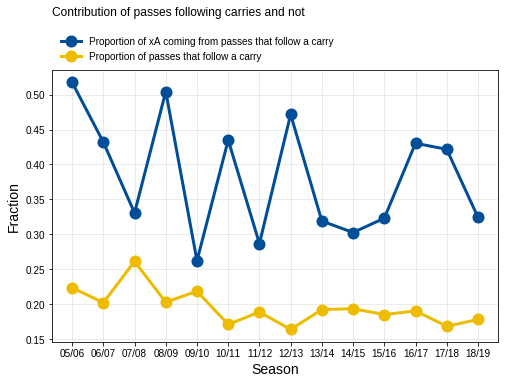

In [637]:
fig, ax = plt.subplots(figsize=(8,5))

ind = np.flip((np.arange(len(years))))
seasons = ['18/19','17/18','16/17','15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06']

ax.plot(ind, pass_c_xA / (pass_nc_xA + pass_c_xA),'-o',label='Proportion of xA coming from passes that follow a carry')
ax.plot(ind, pass_ratio,'-o',label='Proportion of passes that follow a carry')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Fraction')
ax.grid(alpha=0.3)

ax.legend(loc=3,bbox_to_anchor=(0.0,1.0),frameon=False)
ax.text(0.0,1.2,'Contribution of passes following carries and not',transform=ax.transAxes,fontsize=12)
plt.show()

### Using final third passes and progressive carries

In [571]:
pass_c_ft = {}
pass_nc_ft = {}
for year in years:
    from_carry_cond_list = []
    not_from_carry_cond_list = []
    pass_from_carry = m_car_seas[str(year)][m_car_seas[str(year)]['pass_outcome'].notna()]
    for i in m_pass_op_seas[str(year)]['event_id'].values:
        #val = i not in pass_c[str(year)]['outcome_id'].values #m_car_seas['2015']['outcome_id'].values
        #cond_list.append(val)
        from_carry = i in pass_from_carry['outcome_id'].values
        from_carry_cond_list.append(from_carry)
        not_from_carry = i not in pass_from_carry['outcome_id'].values
        not_from_carry_cond_list.append(not_from_carry)
    pass_nc_ft[str(year)] = m_pass_op_seas[str(year)][(not_from_carry_cond_list)&(m_pass_op_seas[str(year)]['end_x'] >= 80)]
    pass_c_ft[str(year)] = m_pass_op_seas[str(year)][(from_carry_cond_list)&(m_pass_op_seas[str(year)]['end_x'] >= 80)]

In [572]:
print(pass_c_ft['2015']['xA'].sum())
print(pass_nc_ft['2015']['xA'].sum())
print(pass_c['2015']['xA'].sum())
print(pass_nc['2015']['xA'].sum())

4.577668559000001
9.592527572
4.577668559
9.592527572


We see that there is no difference between the xA for all passes and just passes into the final third. Therefore, I believe it is more correct to compare to final third passes rather than just all passes (at least for 15/16). 

Also note here that I have also used passes following carries into the final third, rather than all passes following carries.

In [573]:
# Excluding 04/05
years = list(range(2018,2004,-1))

pass_ft_ratio = np.array([len(pass_c_ft[str(years[i])]) / (len(pass_nc_ft[str(years[i])]) + len(pass_c_ft[str(years[i])])) for i in range(len(years))])

pass_nc_ft_xA_p90 = np.array([pass_nc_ft[str(years[i])]['xA'].sum() / m_90_played[i] for i in range(len(years))])
pass_c_ft_xA_p90 = np.array([pass_c_ft[str(years[i])]['xA'].sum() / m_90_played[i] for i in range(len(years))])

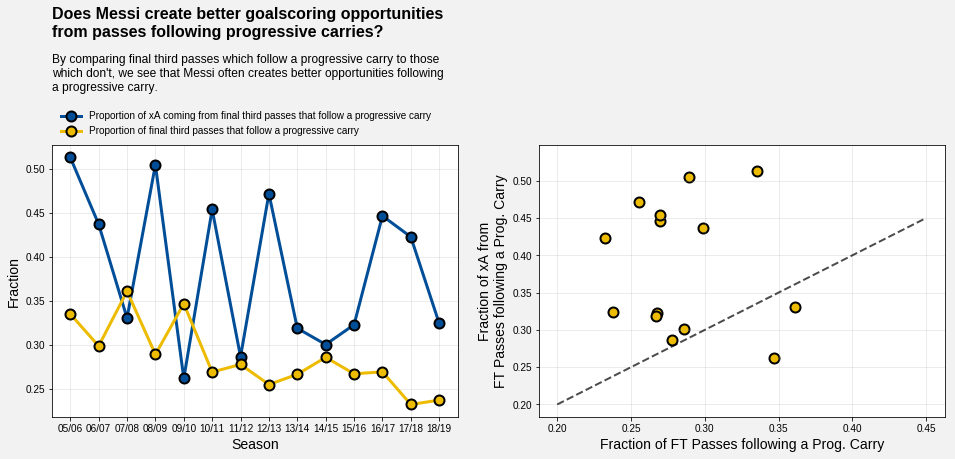

In [574]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5),facecolor='0.95')

ind = np.flip((np.arange(len(years))))
seasons = ['18/19','17/18','16/17','15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06']

ax1.plot(ind, pass_c_ft_xA_p90 / (pass_nc_ft_xA_p90 + pass_c_ft_xA_p90),'-o',mec='k',label='Proportion of xA coming from final third passes that follow a progressive carry')
ax1.plot(ind, pass_ft_ratio,'-o',mec='k',label='Proportion of final third passes that follow a progressive carry')
ax1.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Fraction')
ax1.grid(alpha=0.3)
ax1.legend(loc=3,bbox_to_anchor=(0.0,1.0),frameon=False)
ax1.text(0.0,1.4,'Does Messi create better goalscoring opportunities\nfrom passes following progressive carries?',transform=ax1.transAxes,fontsize=16,fontweight='semibold')
ax1.text(0.0,1.2,'By comparing final third passes which follow a progressive carry to those\nwhich don\'t, we see that Messi often creates better opportunities following\na progressive carry.',transform=ax1.transAxes,fontsize=12)

ax2.scatter(pass_ft_ratio,pass_c_ft_xA_p90 / (pass_nc_ft_xA_p90 + pass_c_ft_xA_p90),c='#edbb00',edgecolors='k',linewidths=2)
ax2.plot([0.2,0.45],[0.2,0.45],'--k',lw=2,alpha=0.7)
ax2.set(xlabel='Fraction of FT Passes following a Prog. Carry',ylabel='Fraction of xA from\nFT Passes following a Prog. Carry')
ax2.grid(alpha=0.3)

plt.show()

In [575]:
car_p_ft = {}
for year in years:
    car_p_ft_cond_list = []
    for i in m_car_seas[str(year)]['outcome_id'].values:
        car_p_ft_cond = i in pass_c_ft[str(year)]['event_id'].values
        car_p_ft_cond_list.append(car_p_ft_cond)
    car_p_ft[str(year)] = m_car_seas[str(year)][car_p_ft_cond_list]

In [576]:
car_s = car_p_ft['2015'][car_p_ft['2015']['pass_outcome'] == 'Successful']
car_u = car_p_ft['2015'][car_p_ft['2015']['pass_outcome'] == 'Unsuccessful']
car_sa = car_p_ft['2015'][(car_p_ft['2015']['pass_outcome'] == 'Shot Assist')]
car_ga = car_p_ft['2015'][(car_p_ft['2015']['pass_outcome'] == 'Goal Assist')]
pass_s = pass_c_ft['2015'][(pass_c_ft['2015']['outcome'] == 'Complete')&
                           (pass_c_ft['2015']['shot_assist'].isnull())&
                          (pass_c_ft['2015']['goal_assist'].isnull())]
pass_u = pass_c_ft['2015'][pass_c_ft['2015']['outcome'] == 'Incomplete']
pass_sa = pass_c_ft['2015'][pass_c_ft['2015']['shot_assist'].notnull()]
pass_ga = pass_c_ft['2015'][pass_c_ft['2015']['goal_assist'].notnull()]

In [577]:
pass_c_ft['2015'].outcome.value_counts()
#car_p_ft['2015'].head()

Complete        214
Incomplete       56
Pass Offside     11
Out               4
Name: outcome, dtype: int64

I need to be careful here as my pass dataset includes *Pass Offside* outcome which is listed as an *Unsuccessful* outcome in the carries but I don't think this is really fair. In the future I should further filter my dataset to exclude the *Pass Offside* outcome.

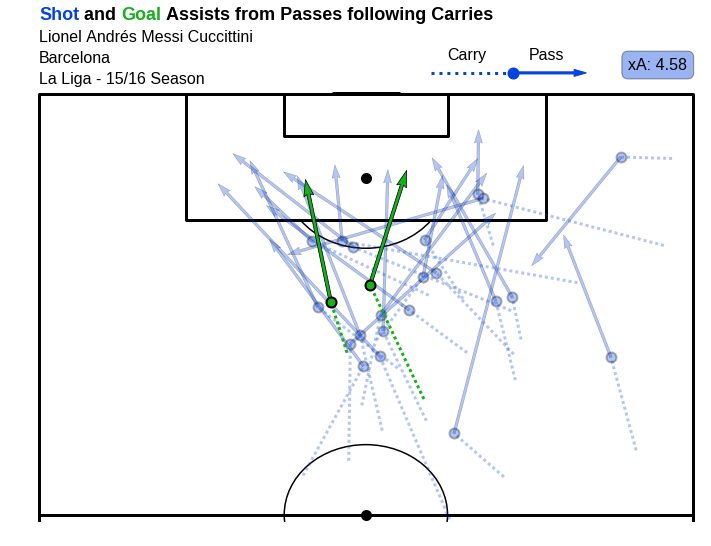

In [578]:
from highlight_text.htext import htext, fig_htext
from matplotlib.lines import Line2D 

fig, ax = draw_pitch('w','k','v','h')

car_s = car_p_ft['2015'][car_p_ft['2015']['pass_outcome'] == 'Successful']
car_u = car_p_ft['2015'][car_p_ft['2015']['pass_outcome'] == 'Unsuccessful']
car_sa = car_p_ft['2015'][(car_p_ft['2015']['pass_outcome'] == 'Shot Assist')]
car_ga = car_p_ft['2015'][(car_p_ft['2015']['pass_outcome'] == 'Goal Assist')]
pass_s = pass_c_ft['2015'][(pass_c_ft['2015']['outcome'] == 'Complete')&
                           (pass_c_ft['2015']['shot_assist'].isnull())&
                          (pass_c_ft['2015']['goal_assist'].isnull())]
pass_u = pass_c_ft['2015'][pass_c_ft['2015']['outcome'] == 'Incomplete']
pass_sa = pass_c_ft['2015'][pass_c_ft['2015']['shot_assist'].notnull()]
pass_ga = pass_c_ft['2015'][pass_c_ft['2015']['goal_assist'].notnull()]

xA_tot = pass_c_ft['2015']['xA'].sum()

xcs = car_s['x'].values
ycs = car_s['y'].values
xcse = car_s['end_x'].values
ycse = car_s['end_y'].values

xcsa = car_sa['x'].values
ycsa = car_sa['y'].values
xcsae = car_sa['end_x'].values
ycsae = car_sa['end_y'].values

xcga = car_ga['x'].values
ycga = car_ga['y'].values
xcgae = car_ga['end_x'].values
ycgae = car_ga['end_y'].values

xps = pass_s['x'].values
yps = pass_s['y'].values
xpse = pass_s['end_x'].values
ypse = pass_s['end_y'].values

xpsa = pass_sa['x'].values
ypsa = pass_sa['y'].values
xpsae = pass_sa['end_x'].values
ypsae = pass_sa['end_y'].values

xpga = pass_ga['x'].values
ypga = pass_ga['y'].values
xpgae = pass_ga['end_x'].values
ypgae = pass_ga['end_y'].values

zo=100
ax.plot([ycsa,ycsae],[xcsa,xcsae],':o',c='xkcd:blue',mec='k',markevery=[1],dashes=(1,1),alpha=0.3,zorder=zo+2)
ax.quiver(ypsa,xpsa,ypsae-ypsa,xpsae-xpsa,angles='xy',scale_units='xy',scale=1,facecolor='xkcd:blue',edgecolor='k',width=0.004,
         linewidth=0.5,alpha=0.3,zorder=zo+2)
ax.plot([ycga,ycgae],[xcga,xcgae],':o',c='xkcd:green',mec='k',markevery=[1],dashes=(1,1),alpha=1,zorder=zo+3)
ax.quiver(ypga,xpga,ypgae-ypga,xpgae-xpga,angles='xy',scale_units='xy',scale=1,lw=1,
          facecolor='xkcd:green',edgecolor='k',width=0.005,linewidth=0.7,alpha=1,zorder=zo+3)

ax.text(0.0,127,messi,ha='left',va='bottom',fontsize=16,zorder=zo)
ax.text(0.0,124,'Barcelona',ha='left',va='bottom',fontsize=16,zorder=zo)
ax.text(0.0,121,'La Liga - 15/16 Season',ha='left',va='bottom',fontsize=16,zorder=zo,)

#ax.scatter(-100,-100,s=100,facecolor='w',edgecolor='xkcd:blue',zorder=zo+3,label='Key Pass')
#ax.scatter(-100,-100,s=100,facecolor='xkcd:blue',edgecolor='xkcd:blue',zorder=zo+3,label='Assist')

#ax.legend(loc=4,bbox_to_anchor=(1.0,1.07),ncol=2,frameon=False,fontsize=12,framealpha=0,facecolor=None)

htext(s = '<Shot> and <Goal> Assists from Passes following Carries',x = 0.0, y = 130,color = 'k', 
      highlight_colors = ['xkcd:blue','xkcd:green'],fontsize=18,string_weight = 'semibold',
      highlight_weights=['semibold'])

#ax.axhline(125,0.5,0.59,c='xkcd:blue',linestyle=':',clip_on=False)
ax.add_line(Line2D([48,58],[123,123],c='xkcd:blue',ls=':',lw=3,marker='o',markevery=[1],clip_on=False,visible=True))
ax.arrow(58,123,9,0,color='xkcd:blue',width=0.3,head_width=1,length_includes_head=True,clip_on=False)

ax.text(50,124.5,'Carry',fontsize=16,ha='left',va='bottom')
ax.text(60,124.5,'Pass',fontsize=16,ha='left',va='bottom')

ax.text(0.98,1.04,'xA: {:.2f}'.format(xA_tot),transform=ax.transAxes,fontsize=16,
        bbox=dict(boxstyle='round,pad=0.4',facecolor='xkcd:blue',edgecolor='k',alpha=0.4),ha='right',zorder=zo)

plt.show()
#fig.savefig('example_plots/carry_map.pdf',bbox_inches='tight')

## Playing Position

In [579]:
m_info = {}
m_info_starts = {}
for year in years:
    m_info[str(year)] = pd.DataFrame([get_player_info(event_data[str(year)][i],messi) for i in range(len(event_data[str(year)]))]).reset_index(drop=True)
    m_info_starts[str(year)] = m_info[str(year)][m_info[str(year)]['position'].notna()]

In [580]:
# Creating DataFrame where rows is the season and columns count amount of games started in that position
pos_played = pd.DataFrame()
for i in pd.concat(m_info_starts).position.unique():
    pos_list = []
    for year in years:
        if str(i) in m_info_starts[str(year)]['position'].value_counts().index:
            pos_list.append(m_info_starts[str(year)]['position'].value_counts().loc[str(i)])
        else:
            pos_list.append(0)
    pos_played[str(i)] = pos_list

# Find number of games started
gp = []
for i in range(len(pos_played)):
    gp.append(pos_played.iloc[i].sum())

In [618]:
#Sorting such that columns are ordered from most common position to least
pos_played = pos_played[pos_played.sum().sort_values(ascending=False).index]

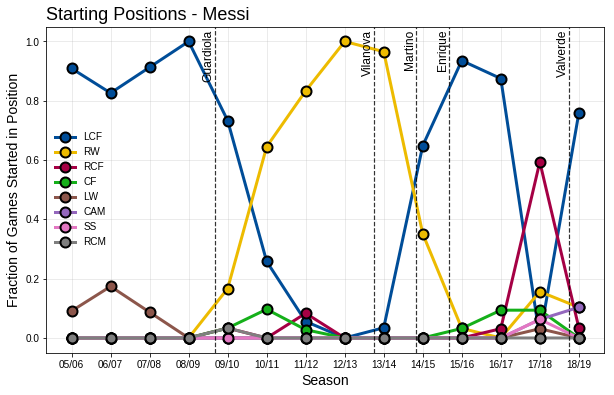

In [636]:
fig, ax = plt.subplots(figsize=(10,6))

ind = np.flip((np.arange(len(years))))
seasons = ['18/19','17/18','16/17','15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06']
#colours = ['#004d98','#edbb00','#a50044','#db0030','xkcd:orange','xkcd:green']
#labels = ['RW','CAM','CF','RCF','RCM','LW']
labels = ['LCF','RW','RCF','CF','LW','CAM','SS','RCM']
man_dates = [0,3+(8/12),7+(9/12),8+(10/12),9+(8/12),12+(9/12)]
man_names = ['Rijkaard','Guardiola','Vilanova','Martino','Enrique','Valverde']

for i in range(len(pos_played.columns)):
    ax.plot(ind, pos_played[str(pos_played.columns[i])].values / np.array(gp),'-o',mec='k',label=labels[i])
    
for i in range(len(man_dates)-1):
    ax.axvline(man_dates[i+1],0,1,c='k',ls='--',lw=1.2,alpha=0.8)
    ax.text(man_dates[i+1],1.04,man_names[i+1],fontsize=12,ha='right',va='top',rotation=90)
    
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Fraction of Games Started in Position')
ax.grid(alpha=0.3)
ax.legend(frameon=False)

ax.text(0.0,1.02,'Starting Positions - Messi',transform=ax.transAxes,fontsize=18)

plt.show()